In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import tensorflow.contrib.distributions as ds

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
sess = tf.InteractiveSession(config = config)

In [5]:
target_loc = -0.25
target_scale = 0.05

In [6]:
eps = 1e-10

In [7]:
batch_size = 3000

In [8]:
def prepare_data(n_samples):
    data = []
    labels = []
    nuisances = []
    
    for i in range(n_samples):
        sig_bkg = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if sig_bkg > 0.5:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [0.0, nuisance], cov = 0.1 * np.array([[1, -0.5], [-0.5, 1]]), size = 1).flatten())
            labels.append(1.0)
        else:
            nuisance = np.random.uniform(low = 0.0, high = 2.0, size = 1)
            data.append(np.random.multivariate_normal(mean = [1.0, nuisance], cov = 0.1 * np.eye(2), size = 1).flatten())
            labels.append(0.0)
            
        nuisances.append(nuisance)
    data = np.array(data)
    labels = np.array(labels)
    nuisances = np.array(nuisances)
    
    return data, labels, nuisances.flatten()

In [41]:
def make_target(nsamples):    
    target_y = np.random.uniform(low = 0.0, high = 2.0, size = (nsamples, 1))
    target_x = np.random.normal(loc = target_loc, scale = target_scale, size = (nsamples, 1))
    
    target_x = np.multiply(target_x, 1 + (target_y - 1) / 3)
    
    return np.concatenate([target_x, target_y], axis = 1)

In [10]:
num_samples = 100000
data_train, labels_train, nuisances_train = prepare_data(num_samples)
nuisances_train = np.expand_dims(nuisances_train, axis = 1)
labels_train = np.expand_dims(labels_train, axis = 1)

In [11]:
train_bkg = labels_train == 0
bkg_data_train = data_train[train_bkg.flatten()]
bkg_labels_train = labels_train[train_bkg.flatten()]
bkg_nuisances_train = nuisances_train[train_bkg.flatten()]

In [12]:
train_sig = labels_train == 1
sig_data_train = data_train[train_sig.flatten()]
sig_labels_train = labels_train[train_sig.flatten()]
sig_nuisances_train = nuisances_train[train_sig.flatten()]

In [13]:
def classifier(data_in, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
        lay = layers.relu(data_in, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 2)
        normalized_outputs = layers.softmax(outputs)

    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)

    return outputs, normalized_outputs, these_vars

In [14]:
def EM_network(data, name):
    with tf.variable_scope(name, reuse = tf.AUTO_REUSE):       
        lay = layers.relu(data, 40)
        lay = layers.relu(lay, 40)
        lay = layers.relu(lay, 20)
        outputs = layers.linear(lay, 1)
        
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = name)
    
    return outputs, these_vars

In [15]:
def make_EM_loss(data_P, data_Q, name):
    local_EM_network_name = name + "_EM_net"
    
    # generator output
    T_P, EM_vars = EM_network(data_P, name = local_EM_network_name)
    
    # target
    T_Q, _ = EM_network(data_Q, name = local_EM_network_name)

    EM_loss = tf.reduce_mean(T_P, axis = 0) - tf.reduce_mean(T_Q, axis = 0)
    
    batch_size_dyn = tf.cast(tf.shape(T_P)[0], tf.int32)
    rand = tf.random.uniform(shape = (batch_size_dyn, 1), minval = 0.0, maxval = 1.0)
    
    # add gradient penalty
    x_grad = tf.math.add(tf.math.multiply(rand, data_P),
                         tf.math.multiply(tf.math.subtract(1.0, rand), data_Q))
    x_grad_EM, _ = EM_network(x_grad, name = local_EM_network_name)
    grad = tf.gradients(x_grad_EM, x_grad)[0]
    
    grad_norm = tf.math.sqrt(tf.reduce_sum(tf.math.square(grad), axis = 1) + eps)
    
    grad_pen = tf.reduce_mean(tf.math.square(grad_norm - 1.0))

    EM_loss_grad_pen = EM_loss[0] + 10 * grad_pen

    return EM_loss_grad_pen, EM_vars, -EM_loss

In [59]:
def make_plots():
    batch_size_test = 100000
    xrange = [-0.5, 0.2]
    yrange = [0, 2]
    
    target_test = make_target(batch_size_test)
        
    inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size_test))
    bkg_batch_data = bkg_data_train[inds_bkg]
    bkg_batch_labels = bkg_labels_train[inds_bkg]
    bkg_batch_nuisances = bkg_nuisances_train[inds_bkg]

    inds_sig = np.random.choice(len(sig_data_train), int(batch_size_test))
    sig_batch_data = sig_data_train[inds_sig]
    sig_batch_labels = sig_labels_train[inds_sig]
    sig_batch_nuisances = sig_nuisances_train[inds_sig]
    
    class_pred_bkg = sess.run(class_out_single, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, nuisance_in: bkg_batch_nuisances})
    class_pred_sig = sess.run(class_out_single, feed_dict = {data_in: sig_batch_data, labels_in: sig_batch_labels, nuisance_in: sig_batch_nuisances})
        
    f, axarr = plt.subplots(3)
    axarr[0].hexbin(x = target_test[:, 0], y = target_test[:, 1], gridsize = 100, bins = 'log')
    axarr[0].set_xlim(xrange)
    axarr[0].set_ylim(yrange)
    axarr[0].set_title("target")
    
    axarr[1].hexbin(x = class_pred_bkg, y = bkg_batch_nuisances, gridsize = 100, bins = 'log')
    axarr[1].set_xlim(xrange)
    axarr[1].set_ylim(yrange)
    axarr[1].set_title("background")
    
    axarr[2].hexbin(x = class_pred_sig, y = sig_batch_nuisances, gridsize = 100, bins = 'log')
    axarr[2].set_xlim(xrange)
    axarr[2].set_ylim(yrange)
    axarr[2].set_title("signal")
        

In [92]:
def make_plots_marginal():
    batch_size_test = 100000
    #batch_size_test = 100
    xrange = [-0.5, 0.2]
    yrange = [0, 2]
    
    target_test = make_target(batch_size_test)
        
    inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size_test))
    bkg_batch_data = bkg_data_train[inds_bkg]
    bkg_batch_labels = bkg_labels_train[inds_bkg]
    bkg_batch_nuisances = bkg_nuisances_train[inds_bkg]

    inds_sig = np.random.choice(len(sig_data_train), int(batch_size_test))
    sig_batch_data = sig_data_train[inds_sig]
    sig_batch_labels = sig_labels_train[inds_sig]
    sig_batch_nuisances = sig_nuisances_train[inds_sig]
    
    class_pred_bkg = sess.run(class_out_single, feed_dict = {data_in: bkg_batch_data, labels_in: bkg_batch_labels, nuisance_in: bkg_batch_nuisances})
    class_pred_sig = sess.run(class_out_single, feed_dict = {data_in: sig_batch_data, labels_in: sig_batch_labels, nuisance_in: sig_batch_nuisances})

    target_ax = sns.jointplot(x = target_test[:, 0], y=target_test[:, 1], kind='kde', xlim = xrange, ylim = yrange)
    bkg_ax = sns.jointplot(x = class_pred_bkg, y=bkg_batch_nuisances, kind='kde', xlim = xrange, ylim = yrange)
    sig_ax = sns.jointplot(x = class_pred_sig, y=sig_batch_nuisances, kind='kde', xlim = xrange, ylim = yrange)
    
    target_ax.set_axis_labels(xlabel = 'classifier output', ylabel = 'nuisance')
    bkg_ax.set_axis_labels(xlabel = 'classifier output', ylabel = 'nuisance')
    sig_ax.set_axis_labels(xlabel = 'classifier output', ylabel = 'nuisance')
    
    target_ax.savefig("2d_bkg_target.pdf")
    bkg_ax.savefig("2d_bkg_distrib.pdf")
    sig_ax.savefig("2d_sig_distrib.pdf")

In [18]:
data_in = tf.placeholder(tf.float32, [None, 2], name = 'data_in')
target_in = tf.placeholder(tf.float32, [None, 2], name = 'target_in')
labels_in = tf.placeholder(tf.float32, [None, 1], name = 'labels_in')
nuisance_in = tf.placeholder(tf.float32, [None, 1], name = 'nuisance_in')

In [19]:
class_out, norm_class_out, gen_vars = classifier(data_in, "gen")

In [20]:
labels_one_hot = tf.squeeze(tf.one_hot(tf.dtypes.cast(labels_in, tf.int32), depth = 2))

In [21]:
classification_loss = tf.losses.softmax_cross_entropy(onehot_labels = labels_one_hot, logits = norm_class_out)

In [22]:
bkg_truth = tf.where(tf.math.less(labels_in, 1))

In [23]:
class_out_single = tf.expand_dims(class_out[:,1], axis = 1)

In [24]:
class_out_bkg = tf.gather_nd(class_out_single, bkg_truth)
class_out_bkg = tf.expand_dims(class_out_bkg, axis = 1)

In [25]:
nuisance_in_bkg = tf.gather_nd(nuisance_in, bkg_truth)
nuisance_in_bkg = tf.expand_dims(nuisance_in_bkg, axis = 1)

In [26]:
output_dist = tf.concat([class_out_bkg, nuisance_in_bkg], axis = 1)

In [27]:
EM_lossval, EM_vars, EM_dist = make_EM_loss(output_dist, target_in, "EM_loss_obj")

In [28]:
total_loss = classification_loss + EM_dist

In [29]:
train_EM = tf.train.AdamOptimizer(learning_rate = 5e-3, beta1 = 0.0, beta2 = 0.5).minimize(EM_lossval, var_list = EM_vars)

In [30]:
train_gen = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(EM_dist, var_list = gen_vars)

In [31]:
train_class_total_loss = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(total_loss, var_list = gen_vars)

In [32]:
train_class = tf.train.AdamOptimizer(learning_rate = 1e-4, beta1 = 0.0, beta2 = 0.5).minimize(classification_loss, var_list = gen_vars)

In [43]:
sess.run(tf.global_variables_initializer())

In [34]:
init_critic = tf.variables_initializer(EM_vars)

In [35]:
sess.run(init_critic)

In [36]:
for i in range(200):
    target = make_target(batch_size)
    inds = np.random.choice(len(bkg_data_train), batch_size)
    data_batch = bkg_data_train[inds]
    labels_batch = bkg_labels_train[inds]
    nuisances_batch = bkg_nuisances_train[inds]
    
    sess.run(train_EM, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                    nuisance_in: nuisances_batch})

    EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                                nuisance_in: nuisances_batch})
    print("EM_dist = {}".format(EM_dist_val))

EM_dist = [0.00677881]
EM_dist = [0.01233868]
EM_dist = [0.01749785]
EM_dist = [0.02050589]
EM_dist = [0.02116984]
EM_dist = [0.03525642]
EM_dist = [0.02927518]
EM_dist = [0.03912655]
EM_dist = [0.03796235]
EM_dist = [0.03467873]
EM_dist = [0.03426638]
EM_dist = [0.02499874]
EM_dist = [0.03280947]
EM_dist = [0.03549093]
EM_dist = [0.03563178]
EM_dist = [0.03156975]
EM_dist = [0.03551668]
EM_dist = [0.03143331]
EM_dist = [0.03114557]
EM_dist = [0.03228763]
EM_dist = [0.03480628]
EM_dist = [0.02903356]
EM_dist = [0.03877085]
EM_dist = [0.02966404]
EM_dist = [0.03488606]
EM_dist = [0.03508812]
EM_dist = [0.02883682]
EM_dist = [0.02893621]
EM_dist = [0.03548959]
EM_dist = [0.03237721]
EM_dist = [0.03784221]
EM_dist = [0.02936591]
EM_dist = [0.03704455]
EM_dist = [0.03175125]
EM_dist = [0.03764972]
EM_dist = [0.03288415]
EM_dist = [0.03459373]
EM_dist = [0.02924608]
EM_dist = [0.03414613]
EM_dist = [0.03102152]
EM_dist = [0.03435895]
EM_dist = [0.02689666]
EM_dist = [0.03615198]
EM_dist = [

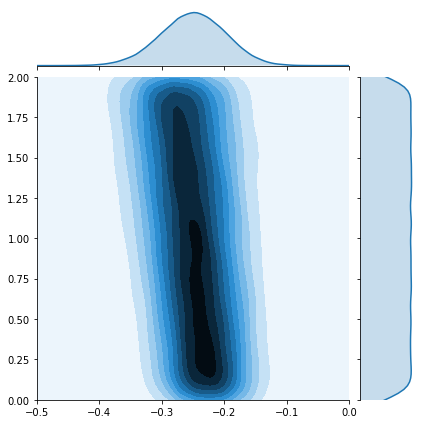

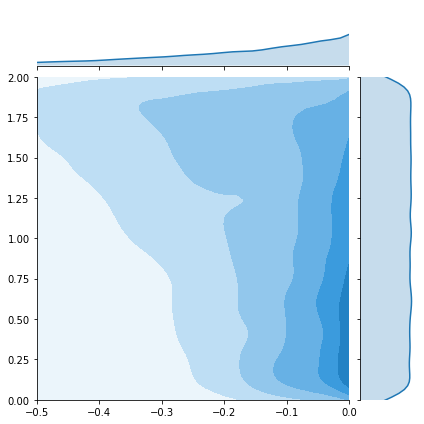

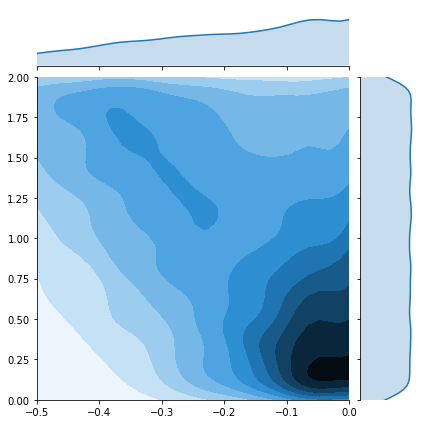

In [42]:
make_plots_marginal()
plt.show()

In [37]:
def perform_training(training_op, epochs, ME_epochs):
    for i in range(0, epochs):
        # prepare noise
        for j in range(ME_epochs):
            target = make_target(batch_size)
            inds = np.random.choice(len(bkg_data_train), batch_size)
            bkg_batch_data = bkg_data_train[inds]
            bkg_batch_labels = bkg_labels_train[inds]
            bkg_batch_nuisances = bkg_nuisances_train[inds]

            sess.run(train_EM, feed_dict = {data_in: bkg_batch_data, target_in: target, labels_in: bkg_batch_labels,
                                           nuisance_in: bkg_batch_nuisances})

        target = make_target(int(batch_size / 2))
        inds = np.random.choice(len(data_train), batch_size)
        data_batch = data_train[inds]

        inds_bkg = np.random.choice(len(bkg_data_train), int(batch_size / 2))
        bkg_batch_data = bkg_data_train[inds_bkg]
        bkg_batch_labels = bkg_labels_train[inds_bkg]
        bkg_batch_nuisances = bkg_nuisances_train[inds_bkg]

        inds_sig = np.random.choice(len(sig_data_train), int(batch_size / 2))
        sig_batch_data = sig_data_train[inds_sig]
        sig_batch_labels = sig_labels_train[inds_sig]
        sig_batch_nuisances = sig_nuisances_train[inds_sig]

        data_batch = np.concatenate([sig_batch_data, bkg_batch_data])
        labels_batch = np.concatenate([sig_batch_labels, bkg_batch_labels])
        nuisances_batch = np.concatenate([sig_batch_nuisances, bkg_batch_nuisances])
                    
        sess.run(training_op, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})
        EM_dist_val = sess.run(EM_dist, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})
        critic_loss = sess.run(EM_lossval, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})
        class_lossval = sess.run(classification_loss, feed_dict = {data_in: data_batch, target_in: target, labels_in: labels_batch,
                                          nuisance_in: nuisances_batch})

        print("W = {}".format(EM_dist_val))
        print("critic loss = {}".format(critic_loss))
        print("class loss = {}".format(class_lossval))

In [73]:
perform_training(train_class_total_loss, epochs = 50, ME_epochs = 300)

W = [0.00326192]
critic loss = 0.04665343463420868
class loss = 0.5854750871658325
W = [0.00750512]
critic loss = 0.016884896904230118
class loss = 0.5822113156318665
W = [0.00332189]
critic loss = 0.010732795111835003
class loss = 0.5833885669708252
W = [0.01109862]
critic loss = 0.013152765110135078
class loss = 0.5809934139251709
W = [-0.00869918]
critic loss = 0.03146695718169212
class loss = 0.5828244686126709
W = [-0.03311872]
critic loss = 0.044397756457328796
class loss = 0.582675039768219
W = [-0.01993334]
critic loss = 0.0378730371594429
class loss = 0.582073986530304
W = [-0.00549161]
critic loss = 0.017769835889339447
class loss = 0.582277774810791
W = [-0.04630494]
critic loss = 0.05437536537647247
class loss = 0.5798627734184265
W = [-0.00353217]
critic loss = 0.011721711605787277
class loss = 0.5807074904441833
W = [0.03892565]
critic loss = -0.027923833578824997
class loss = 0.5825458765029907
W = [-0.0029434]
critic loss = 0.013426339253783226
class loss = 0.5819016695

In [49]:
perform_training(train_class, epochs = 50, ME_epochs = 3)

W = [0.06741034]
critic loss = 0.05419546365737915
class loss = 0.6635038256645203
W = [0.07567039]
critic loss = -0.011059902608394623
class loss = 0.662321150302887
W = [0.06168412]
critic loss = 0.012437783181667328
class loss = 0.6623720526695251
W = [0.06675598]
critic loss = 0.07583649456501007
class loss = 0.6620627641677856
W = [0.06127748]
critic loss = -0.004885386675596237
class loss = 0.6622549891471863
W = [0.06528799]
critic loss = 0.005816817283630371
class loss = 0.6611390113830566
W = [0.05703522]
critic loss = 0.0454607754945755
class loss = 0.6610068082809448
W = [0.06318625]
critic loss = 0.029916442930698395
class loss = 0.6603392362594604
W = [0.05657855]
critic loss = 0.03058898076415062
class loss = 0.6594169735908508
W = [0.06367145]
critic loss = 0.04806746542453766
class loss = 0.6593428254127502
W = [0.0438107]
critic loss = 0.05654453486204147
class loss = 0.6589368581771851
W = [0.05358963]
critic loss = 0.05855053663253784
class loss = 0.6587125658988953


In [129]:
perform_training(train_gen, epochs = 50, ME_epochs = 600)

W = [0.00723767]
critic loss = -0.004893305245786905
class loss = 0.5939866304397583
W = [0.02289891]
critic loss = -0.020109614357352257
class loss = 0.5914429426193237
W = [-0.01040506]
critic loss = 0.014557728543877602
class loss = 0.5950588583946228
W = [0.00352573]
critic loss = -0.0005295283626765013
class loss = 0.6071353554725647
W = [-0.00444913]
critic loss = 0.007093672174960375
class loss = 0.6092406511306763
W = [-0.03821063]
critic loss = 0.04058222100138664
class loss = 0.5993581414222717
W = [0.02276063]
critic loss = -0.020358571782708168
class loss = 0.5916091799736023
W = [0.03695107]
critic loss = -0.034920498728752136
class loss = 0.5998755693435669
W = [0.02502179]
critic loss = -0.023170428350567818
class loss = 0.6025210022926331
W = [-0.00441515]
critic loss = 0.0069176191464066505
class loss = 0.5990334749221802
W = [0.00284243]
critic loss = -0.00010973075404763222
class loss = 0.5882115364074707
W = [0.04406381]
critic loss = -0.04233521595597267
class loss

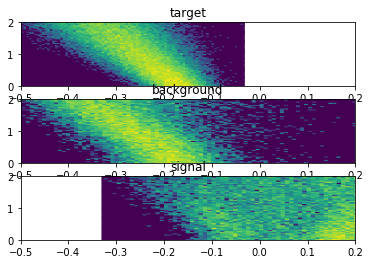

In [74]:
make_plots()
plt.show()
#plt.savefig("shaped_classifier.pdf")

In [93]:
make_plots_marginal()

In [ ]:
plt.show()

In [156]:
data_test = np.loadtxt("data_test.txt")
labels_test = np.loadtxt("labels_test.txt")

In [172]:
pred = sess.run(class_out_single, feed_dict = {data_in: data_test})

In [173]:
from sklearn import metrics

In [174]:
fpr, tpr, thresholds = metrics.roc_curve(labels_test, pred)

In [175]:
LL_pred = np.loadtxt("LL_evaluated.csv")

In [176]:
fpr_LL, tpr_LL, thresholds_LL = metrics.roc_curve(labels_test, LL_pred)

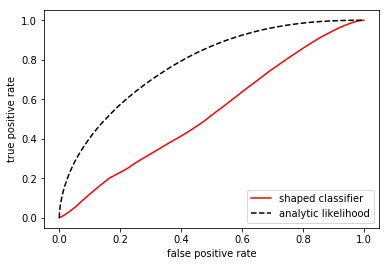

In [177]:
# plot both of them into the same graph
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label = 'shaped classifier', c = 'red')
ax.plot(fpr_LL, tpr_LL, label = 'analytic likelihood', c = 'black', ls = 'dashed')
leg = ax.legend(loc = 'lower right')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()
#plt.savefig("shaped_classifier_ROC.pdf")

In [144]:
metrics.roc_auc_score(labels_test, pred)

0.46547404941485976

In [145]:
metrics.roc_auc_score(labels_test, LL_pred)

0.7783846885778357